### This notebook contains the grid search performed on SVD in order to determinate the most relevant movie embedding (in the context of collaborative filtering) :

### 1. Importation of librairies
### 2. Import and process data
### 3. Grid search on SVD
### 4. Export relevant data to perform implementation of the model in app

## 1. Importation of useful librairies

In [89]:
import pandas as pd
import numpy as np
import csv
import seaborn as sns
import random
import pickle

from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import TruncatedSVD, NMF

## 2. Retrieve data and preprocess it

### a. Let's retrieve our dataset

In [52]:
# data contains ratings of movies by users (over 27 M ratings)
data = pd.read_csv('data/MovieLens/ml-latest/ratings.csv', usecols=['userId','movieId','rating'])
data = data.dropna().reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 635.2 MB


In [53]:
print('the dataset contains {:,} movies rated by {:,} users.'.format(
    len(data['movieId'].unique()),len(data['userId'].unique())))

the dataset contains 53,889 movies rated by 283,228 users.


In [54]:
data.head()

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


### b. Filter data according to the number of ratings per movie and per user.

In [55]:
# Count ratings per movie
count_ratings_per_movie = data[['movieId','rating']].groupby('movieId').count().reset_index(drop=False).\
                                                    rename(columns={'rating':'number_of_ratings_per_movie'})
count_ratings_per_movie.head()

,movieId,number_of_ratings_per_movie
0,1,68469
1,2,27143
2,3,15585
3,4,2989
4,5,15474


In [56]:
# Count ratings per movie
count_ratings_per_user = data[['userId','rating']].groupby('userId').count().reset_index(drop=False).\
                                                    rename(columns={'rating':'number_of_ratings_per_user'})
count_ratings_per_user.head()

,userId,number_of_ratings_per_user
0,1,16
1,2,15
2,3,11
3,4,736
4,5,72


In [57]:
data = pd.merge(data, count_ratings_per_movie, on='movieId')
data = pd.merge(data, count_ratings_per_user, on='userId')
data.head()

,userId,movieId,rating,number_of_ratings_per_movie,number_of_ratings_per_user
0,1,307,3.5,7958,16
1,1,481,3.5,6037,16
2,1,1091,1.5,6138,16
3,1,1257,4.5,5902,16
4,1,1449,4.5,6867,16


In [58]:
# Sparse data is a major issue for matrix factorization. Thus, we decide to keep only movies and users
# with over 1,000 ratings.

In [59]:
data_1000 = data[(data['number_of_ratings_per_user'] >= 1000) & (data['number_of_ratings_per_movie'] >= 1000)]
data_1000 = data_1000.dropna().reset_index(drop=True).drop(['number_of_ratings_per_movie','number_of_ratings_per_user'],axis=1)
data_1000.head()

,userId,movieId,rating
0,214,307,4.0
1,214,481,3.0
2,214,1590,3.0
3,214,2986,2.0
4,214,3020,4.0


### c. Prepare data

#### It's necessary to transform our data into sparse matrix. In order to avoid creating rows/columns with only zeros, we replace the actual user and movies ids by 'id_model' designed on purpose to go from 0 to the number of user/movies.

In [60]:
movieId_model = pd.DataFrame(data_1000['movieId'].unique()).reset_index(drop=False)
movieId_model = movieId_model.rename(columns={'index':'movieId_model',0:'movieId'})
movieId_model.head()

,movieId_model,movieId
0,0,307
1,1,481
2,2,1590
3,3,2986
4,4,3020


In [61]:
userId_model = pd.DataFrame(data_1000['userId'].unique()).reset_index(drop=False)
userId_model = userId_model.rename(columns={'index':'userId_model',0:'userId'})
userId_model.head()

,userId_model,userId
0,0,214
1,1,239
2,2,719
3,3,1933
4,4,2025


In [62]:
data_1000 = pd.merge(data_1000, movieId_model, on='movieId')
data_1000 = pd.merge(data_1000, userId_model, on='userId')
data_1000.head()

,userId,movieId,rating,movieId_model,userId_model
0,214,307,4.0,0,0
1,214,481,3.0,1,0
2,214,1590,3.0,2,0
3,214,2986,2.0,3,0
4,214,3020,4.0,4,0


In [63]:
total_users = len(data_1000['userId_model'].unique())
total_movies =  len(data_1000['movieId_model'].unique())

print('For information, the matrix is meant to contain {:,} rows (sample or user) \
and {:,} columns (item or movies) with {:.0%} of filled data.'.\
      format(total_users,
             total_movies,
             data_1000.shape[0]/(total_users*total_movies)))

For information, the matrix is meant to contain 2,782 rows (sample or user) and 3,931 columns (item or movies) with 29% of filled data.


### d. Create train and test datasets

In [64]:
all_user_id = data_1000['userId_model'].unique()
random.shuffle(all_user_id)

In [65]:
train_size = int(0.80 * len(all_user_id))
train_user_id = all_user_id[:train_size]
test_user_id = list(set(all_user_id) - set(train_user_id))

In [66]:
data_train = pd.merge(pd.DataFrame(train_user_id, columns=['userId_model']),
                      data_1000,
                      on='userId_model')

data_test = pd.merge(pd.DataFrame(test_user_id, columns=['userId_model']),
                      data_1000,
                      on='userId_model')

In [67]:
# We center the ratings based only on train data

In [68]:
avg_movie_rating = data_train.copy()
avg_movie_rating = avg_movie_rating.groupby('movieId').mean()
avg_movie_rating = avg_movie_rating.rename(columns={'rating':'avg_rating'})
avg_movie_rating.head()

,userId_model,userId,avg_rating,movieId_model
movieId,,,,
1,1383.427011,140543.249752,3.851539,16.0
2,1436.149631,141704.094212,3.005234,1204.0
3,1247.844981,140747.238882,2.786531,418.0
4,1049.876448,139664.602317,2.453668,3658.0
5,1319.157830,138003.080148,2.568434,2556.0


In [69]:
data_train = pd.merge(data_train, avg_movie_rating[['avg_rating','movieId_model']], how='left', on='movieId_model')
data_train['rating_for_svd'] = data_train['rating'] - data_train['avg_rating']
data_train.head()

,userId_model,userId,movieId,rating,movieId_model,avg_rating,rating_for_svd
0,702,256243,307,4.0,0,3.835200,0.164800
1,702,256243,2986,2.0,3,2.394220,-0.394220
2,702,256243,2746,3.5,12,3.243860,0.256140
3,702,256243,1221,4.5,13,4.228717,0.271283
4,702,256243,1645,4.0,14,3.324032,0.675968


In [70]:
# We now also remove the avg on the test dataset

In [71]:
data_train_temp = data_train[['movieId_model','avg_rating']].drop_duplicates()

In [72]:
data_test = pd.merge(data_test, data_train_temp, how='left', on='movieId_model')

In [73]:
data_test['rating_for_svd'] = data_test['rating'] - data_test['avg_rating']

In [74]:
data_test.head()

,userId_model,userId,movieId,rating,movieId_model,avg_rating,rating_for_svd
0,0,214,307,4.0,0,3.835200,0.164800
1,0,214,481,3.0,1,3.210361,-0.210361
2,0,214,1590,3.0,2,2.827773,0.172227
3,0,214,2986,2.0,3,2.394220,-0.394220
4,0,214,3020,4.0,4,3.486577,0.513423


In [75]:
# We need both dataset to have the same number of columns to be able to use the .transform of SVD/NMF.
print('cols for a sparse data_train', np.max(data_train['userId_model']))
print('cols for a sparse data_test', np.max(data_test['userId_model']))

cols for a sparse data_train 2781
cols for a sparse data_test 2777


In [76]:
# kind of a hack : we add one line to data test for userId_model = 2781
cols = data_test.columns
data_test = data_test.append(pd.DataFrame([2781,0,0,0,0,0,0],index=cols).T, ignore_index=True)

### e. Convert to sparse matrices

In [77]:
data_train_csr = csr_matrix((data_train['rating_for_svd'],
                             (data_train['userId_model'], data_train['movieId_model']))) # rows = samples (ie users) and cols = features (ie movies)
data_train_csr

<2782x3931 sparse matrix of type '<class 'numpy.float64'>'
	with 2518616 stored elements in Compressed Sparse Row format>

In [78]:
data_test_csr = csr_matrix((data_test['rating_for_svd'],
                             (data_test['userId_model'], data_test['movieId_model']))) # rows = samples (ie users) and cols = features (ie movies)
data_test_csr

<2782x3931 sparse matrix of type '<class 'numpy.float64'>'
	with 643122 stored elements in Compressed Sparse Row format>

## 3. SVD grid search

### This section is dedicated to the implementation of a SVD (Singular Value Decomposition) as a matrix decomposition method targeting the user/rates matrix for all movies.
### The grid search is focused on the parameter which corresponds to the number of components kept for the truncated SVD (https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)

### 3.1 Performing the grid search

In [79]:
GS = {'param_n_components' : [5*i for i in range(1,201)],
     'RMSE': [],'RMSE_train_baseline': [],'MAE_train': [],'MAE_train_baseline': [],
      'RMSE_test':[], 'RMSE_test_baseline': [], 'MAE_test': [],'MAE_test_baseline': []}

In [80]:
GS_to_csv = {'param_n_components' : [],
     'RMSE_train': [],'RMSE_train_baseline': [],'MAE_train': [],'MAE_train_baseline': [],
      'RMSE_test':[], 'RMSE_test_baseline': [], 'MAE_test': [],'MAE_test_baseline': []}

In [46]:
pd.DataFrame(GS_to_csv).to_csv('SVD_grid_search_1000.csv')

In [30]:
%%time
# The 'for' loop is used to try different values of the number of components kept for the truncated SVD.
# Note that the 'baseline model' is simply the averate rate given by the users to a movie.
# We are using here two metrics : RMSE and MAE.
# This interpretation of MAE is very straightforward (mean absolute error).
# In comparison, RMSE penalizes stronger the errors > 1 and put less weight on error < 1.
for n in [5*i for i in range(1,201)]:
    GS_to_csv = {'param_n_components' : [],'RMSE_train': [],
                 'RMSE_train_baseline': [],'MAE_train': [],
                 'MAE_train_baseline': [],'RMSE_test':[], 'RMSE_test_baseline': [],
                 'MAE_test': [],'MAE_test_baseline': []}
    
    GS_to_csv['param_n_components'].append(n)
    
    # Fiting of truncated SVD.
    svd = TruncatedSVD(n_components=n, n_iter=10, random_state=0)
    svd.fit(data_train_csr)
    
    # Computation of RMSE on train
    train_predict_ratings = np.matmul(svd.transform(data_train_csr), svd.components_) # users/movies
    train_predictions = []
    for k in range(data_train.shape[0]):
        i = data_train.iloc[k,0] # userId_model
        j = data_train.iloc[k,4] # movieId_model
        train_predictions.append(train_predict_ratings[i,j] + data_train.iloc[k,5]) #correction on avg
    RMSE_train = np.sqrt(mean_squared_error(data_train['rating'], train_predictions))
    RMSE_train_baseline = np.sqrt(mean_squared_error(data_train['rating'], data_train['avg_rating']))
    MAE_train = mean_absolute_error(data_train['rating'], train_predictions)
    MAE_train_baseline = mean_absolute_error(data_train['rating'], data_train['avg_rating'])
    
    GS_to_csv['RMSE_train'].append(RMSE_train)
    GS_to_csv['RMSE_train_baseline'].append(RMSE_train_baseline)
    GS_to_csv['MAE_train'].append(MAE_train)
    GS_to_csv['MAE_train_baseline'].append(MAE_train_baseline)
    
    # Computation of RMSE on test
    test_predict_ratings = np.matmul(svd.transform(data_test_csr), svd.components_) # users/movies
    test_predictions = []
    for k in range(data_test.shape[0]):
        i = data_test.iloc[k,0] # userId_model
        j = data_test.iloc[k,4] # movieId_model
        test_predictions.append(test_predict_ratings[i,j] + data_test.iloc[k,5])
    
    RMSE_test = np.sqrt(mean_squared_error(data_test['rating'], test_predictions))
    RMSE_test_baseline = np.sqrt(mean_squared_error(data_test['rating'], data_test['avg_rating']))
    MAE_test = mean_absolute_error(data_test['rating'], test_predictions)
    MAE_test_baseline = mean_absolute_error(data_test['rating'], data_test['avg_rating'])

    GS_to_csv['RMSE_test'].append(RMSE_test)
    GS_to_csv['RMSE_test_baseline'].append(RMSE_test_baseline)
    GS_to_csv['MAE_test'].append(MAE_test)
    GS_to_csv['MAE_test_baseline'].append(MAE_test_baseline)
    
    pd.DataFrame(GS_to_csv).to_csv('SVD_grid_search_1000.csv',  mode='a', header=False)
    
    print('\n##################################')
    print('n_components: ', n)
    print('RMSE_train : {}, RMSE_train_baseline : {}.'.format(round(RMSE_train,2), round(RMSE_train_baseline,2)))
    print('MAE_train : {}, MAE_train_baseline : {}.'.format(round(MAE_train,2), round(MAE_train_baseline,2)))
    print('RMSE_test : {}, RMSE_test_baseline : {}.'.format(round(RMSE_test,2), round(RMSE_test_baseline,2)))
    print('MAE_test : {}, MAE_test_baseline : {}.'.format(round(MAE_test,2), round(MAE_test_baseline,2)))



##################################
n_components:  1000
RMSE_train : 0.22, RMSE_train_baseline : 0.91.
MAE_train : 0.16, MAE_train_baseline : 0.71.
RMSE_test : 0.54, RMSE_test_baseline : 0.91.
MAE_test : 0.4, MAE_test_baseline : 0.71.
CPU times: user 2min 59s, sys: 8.13 s, total: 3min 7s
Wall time: 2min 14s


### 3.2 Analysis of the results

In [33]:
data_graph = pd.read_csv('models/SVD_grid_search_1000.csv', index_col=0)[:-1]

In [34]:
data_RMSE = data_graph.drop(['MAE_train', 'MAE_train_baseline', 'MAE_test_baseline','MAE_test'], axis=1)
data_MAE = data_graph.drop(['RMSE_train', 'RMSE_train_baseline', 'RMSE_test_baseline','RMSE_test'], axis=1)

In [35]:
# Graph for RMSE
# the columns names are going to be used automatically in the graph
data_RMSE = data_RMSE.rename(columns={'RMSE_train': 'train', 'RMSE_train_baseline':'train baseline',
                        'RMSE_test':'test', 'RMSE_test_baseline':'test baseline'})

[Text(0.5, 0, 'number of components (for truncated SVD)'),
 Text(0, 0.5, 'RMSE')]

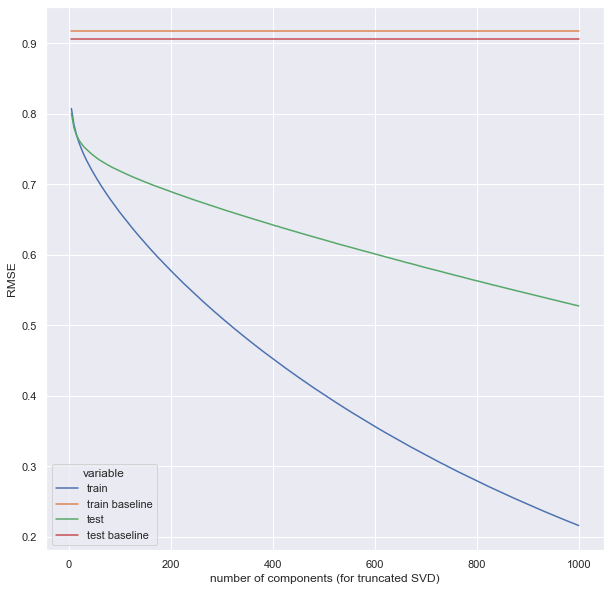

In [36]:
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(10,10)})


ax = sns.lineplot(x='param_n_components', y='value', hue='variable', 
                  data=pd.melt(data_RMSE, ['param_n_components']),
                 )
#ax.set(ylim=(0, 1))
ax.set(xlabel="number of components (for truncated SVD)", ylabel = "RMSE")
#plt.legend(loc='center right')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [37]:
# Graph for MAE
# the columns names are going to be used automatically in the graph
data_MAE = data_MAE.rename(columns={'MAE_train': 'train', 'MAE_train_baseline':'train baseline',
                        'MAE_test':'test', 'MAE_test_baseline':'test baseline'})

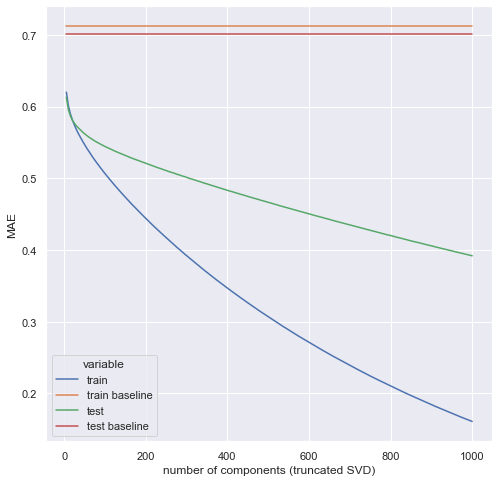

In [38]:
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(8,8)})


ax = sns.lineplot(x='param_n_components', y='value', hue='variable', data=pd.melt(data_MAE, ['param_n_components']))
#ax.set(ylim=(0, 1))
ax.set(xlabel="number of components (truncated SVD)", ylabel = "MAE");

### Considering the results aboved, we decide to implement a truncated SVD with 200 components as it appears to be a balanced choice between :
### - the mathematical performances (MAE on test of ~ 0.52)
### - the concrete understanding of the embedding created thanks to the SVD : 200 dimensions to fully characterize a movie.

### 3.3 Save and export model

In [47]:
# We are now going to train the model on the whole dataset and then export it thanks to pickle.
# First step : prepare data by centering the rates on 0 as we did for the train and test datasets above
# ("fit and transorm" on train and "transform" on test).

In [81]:
avg_movie_rating_all_data = data_1000.copy()
avg_movie_rating_all_data = avg_movie_rating_all_data.groupby('movieId').mean()
avg_movie_rating_all_data = avg_movie_rating_all_data.rename(columns={'rating':'avg_rating'})
avg_movie_rating_all_data.head()

,userId,avg_rating,movieId_model,userId_model
movieId,,,,
1,141035.786365,3.858700,16.0,1382.587396
2,142370.247544,3.008350,1204.0,1433.892436
3,142576.567134,2.782064,418.0,1255.414830
4,142348.684887,2.474277,3658.0,1074.209003
5,139646.251734,2.576809,2556.0,1328.385530


In [82]:
data_1000 = pd.merge(data_1000, avg_movie_rating_all_data[['avg_rating','movieId_model']], how='left', on='movieId_model')
data_1000['rating_for_svd'] = data_1000['rating'] - data_1000['avg_rating']
data_1000.head()

,userId,movieId,rating,movieId_model,userId_model,avg_rating,rating_for_svd
0,214,307,4.0,0,0,3.833761,0.166239
1,214,481,3.0,1,0,3.192164,-0.192164
2,214,1590,3.0,2,0,2.823403,0.176597
3,214,2986,2.0,3,0,2.439843,-0.439843
4,214,3020,4.0,4,0,3.490952,0.509048


In [83]:
data_1000_csr = csr_matrix((data_1000['rating_for_svd'],
                             (data_1000['userId_model'], data_1000['movieId_model']))) # rows = samples (ie users) and cols = features (ie movies)
data_1000_csr

<2782x3931 sparse matrix of type '<class 'numpy.float64'>'
	with 3161737 stored elements in Compressed Sparse Row format>

In [84]:
%%time
svd = TruncatedSVD(n_components=200, n_iter=10, random_state=0)
svd.fit(data_1000_csr)

CPU times: user 26.2 s, sys: 5.26 s, total: 31.5 s
Wall time: 4.19 s


TruncatedSVD(n_components=200, n_iter=10, random_state=0)

In [85]:
pickle.dump(svd, open('svd.sav','wb'))

In [86]:
predict_ratings = np.matmul(svd.transform(data_1000_csr), svd.components_) # users/movies
predictions = []
for k in range(data_1000.shape[0]):
    i = data_1000.iloc[k,4] # userId_model
    j = data_1000.iloc[k,3] # movieId_model
    predictions.append(predict_ratings[i,j] + data_1000.iloc[k,5]) #correction on avg
RMSE = np.sqrt(mean_squared_error(data_1000['rating'], predictions))
RMSE_baseline = np.sqrt(mean_squared_error(data_1000['rating'], data_1000['avg_rating']))
MAE = mean_absolute_error(data_1000['rating'], predictions)
MAE_baseline = mean_absolute_error(data_1000['rating'], data_1000['avg_rating'])    

In [88]:
print('\n*** Check of the performances on the whole dataset as train data ***')
print('RMSE : {}, RMSEbaseline : {}.'.format(round(RMSE_train,2), round(RMSE_train_baseline,2)))
print('MAE : {}, MAE_baseline : {}.'.format(round(MAE_train,2), round(MAE_train_baseline,2)))


*** Check of the performances on the whole dataset as train data ***
RMSE : 0.22, RMSEbaseline : 0.91.
MAE : 0.16, MAE_baseline : 0.71.


## 4. Export data for the implementation of the model

#### In order to implement in the app the model trained in this notebook, we need to add to each movie in the database its average rating and its 'model_ID'.

In [97]:
# Record matches between movies pk in the database, movie id in the SVD model and movie average rating.

In [93]:
df_movie_id = pd.read_csv('data/MovieLens/ml-latest/links.csv', usecols=['movieId','imdbId'])

In [94]:
model_and_imdb = pd.merge(data_1000, df_movie_id, on='movieId')
model_and_imdb = model_and_imdb[['movieId_model','imdbId', 'avg_rating']]
model_and_imdb = model_and_imdb.rename(columns={'imdbId':'imdb_title_id'})
model_and_imdb = model_and_imdb.drop_duplicates()
model_and_imdb

,movieId_model,imdb_title_id,avg_rating
0,0,108394,3.833761
779,1,107302,3.192164
1583,2,119081,2.823403
2976,3,100502,2.439843
4123,4,106856,3.490952
...,...,...,...
3160514,3926,118750,2.356884
3160790,3927,115580,2.728571
3160965,3928,4368814,3.780000
3161165,3929,2120120,2.401316


In [98]:
pk_and_imdb = pd.read_json('data/data_for_app/movie_data.json')
pk_and_imdb['imdb_title_id'] = pk_and_imdb['fields'].apply(lambda x : x['imdbid'])
pk_and_imdb['imdb_title_id'] = pk_and_imdb['imdb_title_id'].apply(lambda x : int(x.replace('tt', '')))
pk_and_imdb = pk_and_imdb[['pk','imdb_title_id']]
pk_and_imdb

,pk,imdb_title_id
0,1,9
1,2,574
2,3,1892
3,4,2101
4,5,2130
...,...,...
85850,85851,9908390
85851,85852,9911196
85852,85853,9911774
85853,85854,9914286


In [99]:
id_to_export = pd.merge(pk_and_imdb, model_and_imdb, how='left')
id_to_export['movieId_model'].dropna()

165      2769.0
251      2537.0
297       991.0
401      2766.0
415      2508.0
          ...  
77571    2365.0
77666    2519.0
77741    3042.0
77748    3887.0
78070    1186.0
Name: movieId_model, Length: 3786, dtype: float64

In [102]:
# on each row we have :
# 0 : index
# 1 : movie pk in database
# 2 : movie IMDB identifier
# 3 : movie id model
# 4 : movie average rating
id_to_export.to_csv('modelIds_and_avgRatings.csv', header=None)